# phase 1: Data Acquisition, Data Preparation & Exploratory Data Analysis

## 1. Environment set up and Data Acquisition:

To get set up we will follow the following steps:

1. we will first load the packages we need for phase 1
2. we will scrape the Column names:
    1. make a request to the Names file
    2. regex to capture column names
    3. remove extra that got grabbed in scrape
    4. insert Poisonous in first position (it was excluded as it is not an attribute )
3. To acquire data and combine with 2. 

In [170]:
#1 package loading:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re


# get columns names froms names file
#location of names
http = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names'
#request to names file
req = requests.request('get',url = http)
#search to match columns
search = re.compile('[0-9]{1,2}. ([-?\w]+):')
#finding based on search droping some extra data
names = search.findall(req.text)[3:]
#inserting poisonous which was not listed in atribute list
names.insert(0,'poisonous')

#created Data frame with data plus names dirived above
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',names = names)

#sanity check
df.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 2. Data prep feature engineering:

as we read about in [Week13 readings](https://elitedatascience.com/feature-engineering)  and in class their are several processes that we should embark on before doing any predictions on a data set. these include:

- subsetting - the features we plan on utilizing in our model are the only ones we will process to simplify everything below
- Handling missing data - most modeling algorithms require data that is free from gaps (no nulls)
- combining sparse classes - categorical classes that have very few records can lead to overfit models 
- Adding dummy variables -  for each categorical value we will create a Boolean indicator value

### Creating subset:

Now that we have all the data we are ready to do some prep. first we will create the subset with the following features:

1. Poisonous - our outcome of interest
2. odor (required as part of assignment)
3. spore-print-color (selected because I know how useful this is in mushroom identification)
4. bruises? (as I know some mushrooms with volatile chemicals in them react to air I am curious if this can be utlize to predict poisonousness)

In [171]:
# selecting collumns
columns = ['poisonous','odor','bruises?', 'spore-print-color']
#creating subset
df_for_pred = df.loc[:,columns]

### checking for null values

In [172]:
df_for_pred.isnull().sum()

poisonous            0
odor                 0
bruises?             0
spore-print-color    0
dtype: int64

conclusion: the dataset is free from nulls



### combining sparse classes 
#### Initial visualizing:

To aid in identifying spares classes and learning more about our data we will create visualizations of each of our data points. As they are all categorical these will be bar charts 

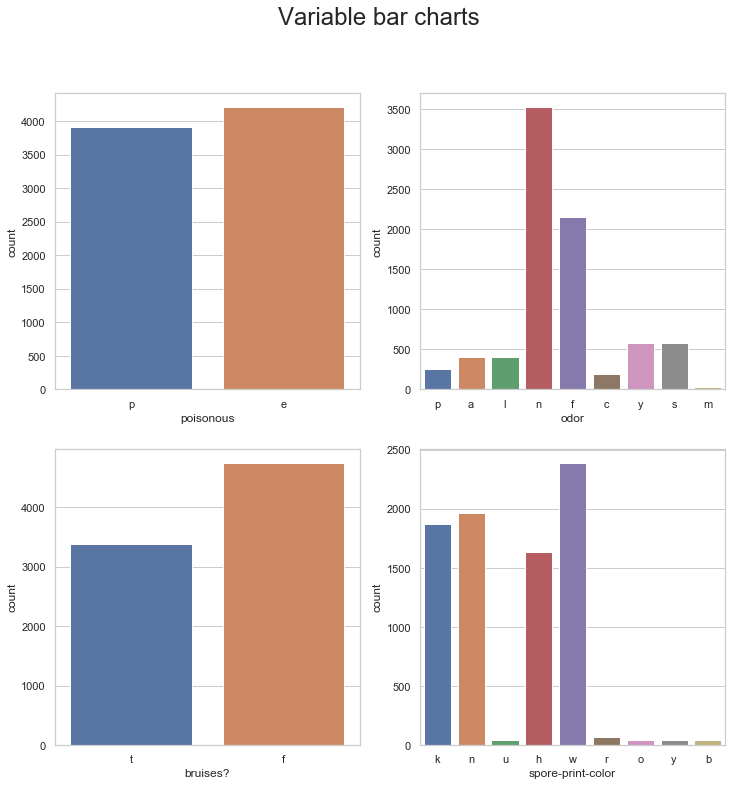

In [173]:
# barchart of subset variables
plt.figure(figsize=(12,12));
plt.suptitle('Variable bar charts',fontsize=24)
plt.tight_layout();
plt.subplot(2,2,1);
sns.countplot(x='poisonous', data = df_for_pred);
plt.subplot(2,2,2);
sns.countplot(x='odor', data=df_for_pred);
plt.subplot(2,2,3);
sns.countplot(x='bruises?', data=df_for_pred);
plt.subplot(2,2,4);
sns.countplot(x='spore-print-color',data=df_for_pred);

**conclusions:** 

**sparse classes**
The spore-print-color variable appears to have several sparse classes that we should investigate combining. Odor could also be considered but will be excluded as it is included on the assignments direction their is no mention of this process in the directions provided.

**other:** 
other conclusions that can be taken out of this initial look at our data.
Poisonous - our observations appear to be approximatly 
#### counting

we will next look at the value counts and decide what classes from spore print color to combine

In [174]:
display(df_for_pred['spore-print-color'].value_counts())

w    2388
n    1968
k    1872
h    1632
r      72
y      48
b      48
o      48
u      48
Name: spore-print-color, dtype: int64

#### Combining spares classes

The classes `r, u, b, o , y` will all be combined into a variable `other` they all have a fraction of the number of observations of the other values.

In [175]:
#setting sparse to other with isin method 
df_for_pred.loc[df_for_pred['spore-print-color'].isin(['r','u','b','o','y']),'spore-print-color'] = 'other'

#sanity check 
display(df_for_pred['spore-print-color'].value_counts())

w        2388
n        1968
k        1872
h        1632
other     264
Name: spore-print-color, dtype: int64

### Adding dummy variables: 

all of our variables will require some modification to make them ready for predictive modeling.

- Poisonous: as it has only 2 values we will make an in-line update and set P = to 1 and E = to 0 

- Bruises?: has two values T/F we will make t = 1 and f = 0

- spore-print-color and odor have `14` values between them (after combining sparse classes ) so we will utilize the `.get_dummies`  pandas function to split them in indicator variables so that our**analytical base table (ABT)** will contain `16` columns

#### 1.Poisonous & Bruises?

In [176]:
#setting Poisonous = p to 1
df_for_pred.poisonous = (df_for_pred.poisonous == 'p').astype(int)
#verification
df_for_pred.poisonous.value_counts()

0    4208
1    3916
Name: poisonous, dtype: int64

In [177]:
#setting bruises? = t to 1
df_for_pred['bruises?'] = (df_for_pred['bruises?'] =='t').astype(int)

#sanity check 
df_for_pred['bruises?'].value_counts()

0    4748
1    3376
Name: bruises?, dtype: int64

#### 2.Spore-Print-color & Odor Get_Dummies

In [178]:
#get dummies function
df_with_dummies = pd.get_dummies(df_for_pred)
#sanity check
df_with_dummies.head()

,poisonous,bruises?,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_other,spore-print-color_w
0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


## 3. EDA: exploratory data analysis: 

We will now finish the exploratory analysis [started above](#Initial-visualizing%3A) by looking at the relationship between our indicator (Poisonous) and  our predictor values.
### 1.Bruises & Poisonous:

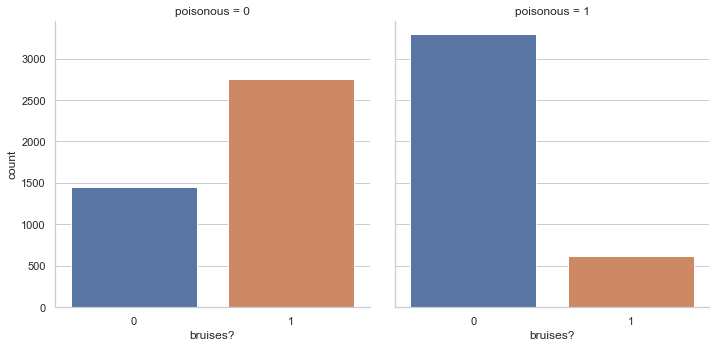

In [56]:
sns.catplot('bruises?',col ='poisonous',kind='count',data=df_for_pred);

**conclusions:**

Mushrooms that bruise appear to be more likely to to not be poisonous and mushrooms that don't bruise appear to be much more likely to be poisonous 

### 2. Spore print color:

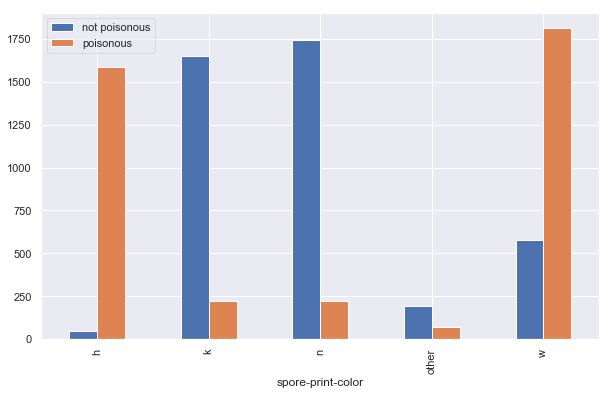

In [222]:
ax= pd.crosstab(df_for_pred['spore-print-color'],df_for_pred.poisonous).plot.bar(figsize=(10,6));           
ax.legend(['not poisonous','poisonous'],loc = 0,framealpha = .6);

**conclusions:**

spore print colors `h` and `w` appear to be significantly more likely to be poisonous

while `k`, `n` & `other` are much more likely to be not poisonous  

### 3. Odor:

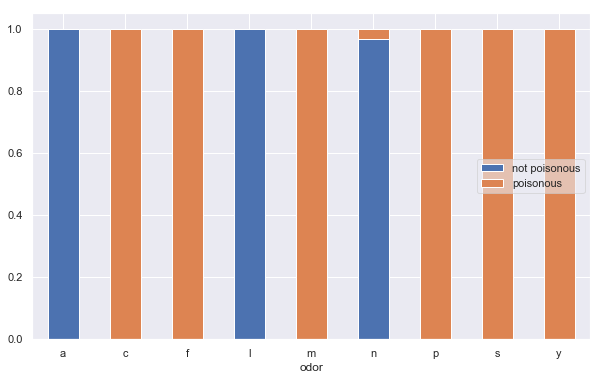

In [223]:
table = pd.crosstab(df_for_pred.odor,df_for_pred.poisonous)
ax = table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(10,6))
plt.xticks(rotation=0);
ax.legend(['not poisonous','poisonous'],loc = 5,framealpha = .6);

**conclusions:**

while odor `n` is highly correlated to being not poisonous it is the worst predictor of the group the rest of the odor variables are perfect predictors of whether a mushroom is poisonous

### EDA conclusions

while `Bruises?` and `sport print color` have some correlation to whether a mushroom is poisonous `odor`has a Very strong correlation and will be the strongest predictor of the bunch.

____

# Phase 2: Build Predictive Models

In [226]:
# load the LogisticRegression and metrics functions
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# set y varible with poisonous 
y  = df_with_dummies.poisonous.values
# set a predictors varible starting with all varibles 
predictors = df_with_dummies.columns.values[1:]
#set a x_train varible 
X = df_with_dummies[predictors].values

#sanity check x_train
print(X[:5])

[[1 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]]
[1 0 0 1 0]


In [227]:
#saniy check Y_train
y[:5]

array([1, 0, 0, 1, 0])

## null error rate

In [75]:
df_for_pred.poisonous.sum()/df_for_pred.shape[0]

0.48202855736090594

In [71]:
# initialize a Logistic 
model = LogisticRegression(solver = 'lbfgs') # set to remove warning and set to soon to be new default 
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
model.score(X_train,y_train)

0.9852289512555391

In [141]:
for e,p in enumerate(predictors):
    print(f'{p} = {model.coef_[0][e]}')
    

bruises? = 0.9845965282309062
odor_a = -6.370764481090044
odor_c = 4.420225157911981
odor_f = 3.76038211006417
odor_l = -6.370764481090044
odor_m = 0.9214413785275798
odor_n = -5.538748545635588
odor_p = 3.86546193244749
odor_s = 2.655848383087907
odor_y = 2.65584838308791
spore-print-color_h = 0.83220191234103
spore-print-color_k = -2.2578961444188193
spore-print-color_n = -2.2760811411417
spore-print-color_other = 2.5765869553793483
spore-print-color_w = 1.124118255151537


In [111]:
y_pred = model.predict(X_train)
y_pred[:5]

array([1, 0, 0, 1, 0])

In [131]:
print(metrics.classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4208
           1       1.00      0.97      0.98      3916

   micro avg       0.99      0.99      0.99      8124
   macro avg       0.99      0.98      0.99      8124
weighted avg       0.99      0.99      0.99      8124

